Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.3) 미래에 볼 영화의 평점 예측하기

### 바로가기

- [<Step1. 탐색> : MovieLens 데이터 살펴보기](#<Step1.-탐색>-:-MovieLens-데이터-살펴보기)
    - [MovieLens 데이터셋의 기본 정보]
- [<Step2. 분석> : 탐색적 데이터 분석](#<Step2.-분석>-:-탐색적-데이터-분석)
    - [분석할 영화의 정보 탐색하기]
    - [장르의 속성 탐색]
    - [분석할 유저의 정보 탐색하기]
    - [평점 데이터의 정보 탐색하기]
    - [user-movie 형태의 테이블로 살펴보기]
- [<Step3. 예측> : 수학적 기법을 활용한 평점 예측](#<Step3.-예측>-:-수학적-기법을-활용한-평점-예측)
    - [SVD를 활용한 빈칸 채우기]
    - [아직 평가하지 않은 영화의 점수 예측하기]
- [<Step4. 평가> : 예측 모델 평가하기](#<Step4.-평가>-:-예측-모델-평가하기)
    - [예측 모델의 평가 방법]
    - [실제 평점과의 비교 시각화]
    - [한걸음 더 : 20대가 좋아할만한 영화를 예측해보자]

-----

In [4]:
# -*- coding: utf-8 -*-

%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : MovieLens 데이터 살펴보기

### [MovieLens 데이터셋의 기본 정보]

In [19]:
# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "../data/ml-1m/ratings.dat"
movie_file_path = "../data/ml-1m/movies.dat"
user_file_path = "../data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::',encoding='latin-1')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

In [5]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


-----

# <Step2. 분석> : 탐색적 데이터 분석

### [분석할 영화의 정보 탐색하기]

In [6]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

-----

### `[미니 퀴즈 - 3.3]`
- `영화 데이터에 대한 탐색적 데이터 분석을 더 실행해 봅시다. 영화의 연대별 갯수를 탐색해 보세요.`

In [8]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
# 새로운 column을 만들어버리기
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

      movie_id                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
3878      3948             Meet the Parents (2000)   
3879      3949          Requiem for a Dream (2000)   
3880      3950                    Tigerland (2000)   
3881      3951             Two Family House (2000)   
3882      3952               Contender, The (2000)   

                             genre  year year_term  
0      Animation|Children's|Comedy  1995      1990  
1     Adventure|Children's|Fantasy  1995      1990  
2                   Comedy|Romance  1995      1990  
3                     Comedy|Drama  1995      1990  
4                           Comedy  1995      1990  
...                            ..

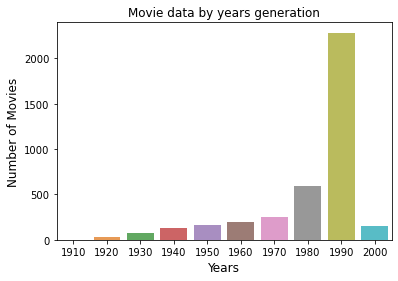

In [16]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

-----

### [장르의 속성 탐색] 

In [10]:
# 가장 많이 사용된 장르의 조합을 출력합니다. (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

-----

In [21]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    #print(movie_data)
    #print(index)
    print(row)
    # genre 피처를 ‘|’ 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

movie_id                               1
title                   Toy Story (1995)
genre        Animation|Children's|Comedy
year                                1995
year_term                           1990
Name: 0, dtype: object
movie_id                                2
title                      Jumanji (1995)
genre        Adventure|Children's|Fantasy
year                                 1995
year_term                            1990
Name: 1, dtype: object
movie_id                           3
title        Grumpier Old Men (1995)
genre                 Comedy|Romance
year                            1995
year_term                       1990
Name: 2, dtype: object
movie_id                            4
title        Waiting to Exhale (1995)
genre                    Comedy|Drama
year                             1995
year_term                        1990
Name: 3, dtype: object
movie_id                                      5
title        Father of the Bride Part II (1995)
genre                 

Name: 341, dtype: object
movie_id                 346
title        Backbeat (1993)
genre          Drama|Musical
year                    1993
year_term               1990
Name: 342, dtype: object
movie_id                    347
title        Bitter Moon (1992)
genre                     Drama
year                       1992
year_term                  1990
Name: 343, dtype: object
movie_id                              348
title        Bullets Over Broadway (1994)
genre                              Comedy
year                                 1994
year_term                            1990
Name: 344, dtype: object
movie_id                                 349
title        Clear and Present Danger (1994)
genre              Action|Adventure|Thriller
year                                    1994
year_term                               1990
Name: 345, dtype: object
movie_id                        350
title            Client, The (1994)
genre        Drama|Mystery|Thriller
year                       

Name: 657, dtype: object
movie_id                 664
title        Faithful (1996)
genre                 Comedy
year                    1996
year_term               1990
Name: 658, dtype: object
movie_id                    665
title        Underground (1995)
genre                       War
year                       1995
year_term                  1990
Name: 659, dtype: object
movie_id                        666
title        All Things Fair (1996)
genre                         Drama
year                           1996
year_term                      1990
Name: 660, dtype: object
movie_id                     667
title        Bloodsport 2 (1995)
genre                     Action
year                        1995
year_term                   1990
Name: 661, dtype: object
movie_id                        668
title        Pather Panchali (1955)
genre                         Drama
year                           1955
year_term                      1950
Name: 662, dtype: object
movie_id            

Name: 967, dtype: object
movie_id                              980
title        In the Line of Duty 2 (1987)
genre                              Action
year                                 1987
year_term                            1980
Name: 968, dtype: object
movie_id                         981
title        Dangerous Ground (1997)
genre                          Drama
year                            1997
year_term                       1990
Name: 969, dtype: object
movie_id               982
title        Picnic (1955)
genre                Drama
year                  1955
year_term             1950
Name: 970, dtype: object
movie_id                        983
title        Madagascar Skin (1995)
genre                       Romance
year                           1995
year_term                      1990
Name: 971, dtype: object
movie_id                              984
title        Pompatus of Love, The (1996)
genre                        Comedy|Drama
year                                 19

Name: 1240, dtype: object
movie_id                                   1261
title        Evil Dead II (Dead By Dawn) (1987)
genre            Action|Adventure|Comedy|Horror
year                                       1987
year_term                                  1980
Name: 1241, dtype: object
movie_id                         1262
title        Great Escape, The (1963)
genre                   Adventure|War
year                             1963
year_term                        1960
Name: 1242, dtype: object
movie_id                        1263
title        Deer Hunter, The (1978)
genre                      Drama|War
year                            1978
year_term                       1970
Name: 1243, dtype: object
movie_id                                      1264
title                                  Diva (1981)
genre        Action|Drama|Mystery|Romance|Thriller
year                                          1981
year_term                                     1980
Name: 1244, dtype: object


Name: 1483, dtype: object
movie_id                      1519
title        Broken English (1996)
genre                        Drama
year                          1996
year_term                     1990
Name: 1484, dtype: object
movie_id                    1520
title        Commandments (1997)
genre                    Romance
year                        1997
year_term                   1990
Name: 1485, dtype: object
movie_id            1522
title        Ripe (1996)
genre              Drama
year                1996
year_term           1990
Name: 1486, dtype: object
movie_id                                   1523
title        Truth or Consequences, N.M. (1997)
genre                      Action|Crime|Romance
year                                       1997
year_term                                  1990
Name: 1487, dtype: object
movie_id                    1524
title        Turning, The (1992)
genre                      Drama
year                        1992
year_term                   1990


movie_id                         1743
title        Arguing the World (1996)
genre                     Documentary
year                             1996
year_term                        1990
Name: 1692, dtype: object
movie_id                          1744
title                 Firestorm (1998)
genre        Action|Adventure|Thriller
year                              1998
year_term                         1990
Name: 1693, dtype: object
movie_id                 1746
title        Senseless (1998)
genre                  Comedy
year                     1998
year_term                1990
Name: 1694, dtype: object
movie_id                   1747
title        Wag the Dog (1997)
genre              Comedy|Drama
year                       1997
year_term                  1990
Name: 1695, dtype: object
movie_id                          1748
title                 Dark City (1998)
genre        Film-Noir|Sci-Fi|Thriller
year                              1998
year_term                         1990
Name: 

Name: 1930, dtype: object
movie_id                          2000
title             Lethal Weapon (1987)
genre        Action|Comedy|Crime|Drama
year                              1987
year_term                         1980
Name: 1931, dtype: object
movie_id                          2001
title           Lethal Weapon 2 (1989)
genre        Action|Comedy|Crime|Drama
year                              1989
year_term                         1980
Name: 1932, dtype: object
movie_id                          2002
title           Lethal Weapon 3 (1992)
genre        Action|Comedy|Crime|Drama
year                              1992
year_term                         1990
Name: 1933, dtype: object
movie_id                2003
title        Gremlins (1984)
genre          Comedy|Horror
year                    1984
year_term               1980
Name: 1934, dtype: object
movie_id                                 2004
title        Gremlins 2: The New Batch (1990)
genre                           Comedy|Horror
ye

Name: 2179, dtype: object
movie_id                      2249
title        My Blue Heaven (1990)
genre                       Comedy
year                          1990
year_term                     1990
Name: 2180, dtype: object
movie_id                       2250
title        Men Don't Leave (1990)
genre                         Drama
year                           1990
year_term                      1990
Name: 2181, dtype: object
movie_id                                   2251
title        Cabinet of Dr. Ramirez, The (1991)
genre                                    Comedy
year                                       1991
year_term                                  1990
Name: 2182, dtype: object
movie_id             2252
title         Hero (1992)
genre        Comedy|Drama
year                 1992
year_term            1990
Name: 2183, dtype: object
movie_id                      2253
title                  Toys (1992)
genre        Action|Comedy|Fantasy
year                          1992
year_

Name: 2421, dtype: object
movie_id                           2491
title        Simply Irresistible (1999)
genre                    Comedy|Romance
year                               1999
year_term                          1990
Name: 2422, dtype: object
movie_id                2492
title        20 Dates (1998)
genre                 Comedy
year                    1998
year_term               1990
Name: 2423, dtype: object
movie_id                       2493
title        Harmonists, The (1997)
genre                         Drama
year                           1997
year_term                      1990
Name: 2424, dtype: object
movie_id                      2494
title        Last Days, The (1998)
genre                  Documentary
year                          1998
year_term                     1990
Name: 2425, dtype: object
movie_id                                                  2495
title        Fantastic Planet, The (La Planète sauvage) (1973)
genre                                       

Name: 2719, dtype: object
movie_id                       2789
title        Damien: Omen II (1978)
genre                        Horror
year                           1978
year_term                      1970
Name: 2720, dtype: object
movie_id                                                  2790
title        Final Conflict, The (a.k.a. Omen III: The Fina...
genre                                                   Horror
year                                                      1981
year_term                                                 1980
Name: 2721, dtype: object
movie_id                 2791
title        Airplane! (1980)
genre                  Comedy
year                     1980
year_term                1980
Name: 2722, dtype: object
movie_id                               2792
title        Airplane II: The Sequel (1982)
genre                                Comedy
year                                   1982
year_term                              1980
Name: 2723, dtype: object
movie

Name: 2925, dtype: object
movie_id                                  2995
title        House on Haunted Hill, The (1999)
genre                                   Horror
year                                      1999
year_term                                 1990
Name: 2926, dtype: object
movie_id                          2996
title        Music of the Heart (1999)
genre                            Drama
year                              1999
year_term                         1990
Name: 2927, dtype: object
movie_id                            2997
title        Being John Malkovich (1999)
genre                             Comedy
year                                1999
year_term                           1990
Name: 2928, dtype: object
movie_id                               2998
title        Dreaming of Joseph Lees (1998)
genre                               Romance
year                                   1998
year_term                              1990
Name: 2929, dtype: object
movie_id       

Name: 3155, dtype: object
movie_id                   3225
title        Down to You (2000)
genre            Comedy|Romance
year                       2000
year_term                  2000
Name: 3156, dtype: object
movie_id                              3226
title        Hellhounds on My Trail (1999)
genre                          Documentary
year                                  1999
year_term                             1990
Name: 3157, dtype: object
movie_id                                                  3227
title        Not Love, Just Frenzy (Más que amor, frenesí) ...
genre                                    Comedy|Drama|Thriller
year                                                      1996
year_term                                                 1990
Name: 3158, dtype: object
movie_id                      3228
title        Wirey Spindell (1999)
genre                       Comedy
year                          1999
year_term                     1990
Name: 3159, dtype: object
movie

Name: 3362, dtype: object
movie_id                    3432
title        Death Wish 3 (1985)
genre               Action|Drama
year                        1985
year_term                   1980
Name: 3363, dtype: object
movie_id                                   3433
title        Death Wish 4: The Crackdown (1987)
genre                              Action|Drama
year                                       1987
year_term                                  1980
Name: 3364, dtype: object
movie_id                                       3434
title        Death Wish V: The Face of Death (1994)
genre                                  Action|Drama
year                                           1994
year_term                                      1990
Name: 3365, dtype: object
movie_id                        3435
title        Double Indemnity (1944)
genre                Crime|Film-Noir
year                            1944
year_term                       1940
Name: 3366, dtype: object
movie_id            

Name: 3636, dtype: object
movie_id                           3706
title                Angel Heart (1987)
genre        Film-Noir|Mystery|Thriller
year                               1987
year_term                          1980
Name: 3637, dtype: object
movie_id                      3707
title        Nine 1/2 Weeks (1986)
genre                        Drama
year                          1986
year_term                     1980
Name: 3638, dtype: object
movie_id                   3708
title        Firestarter (1984)
genre           Horror|Thriller
year                       1984
year_term                  1980
Name: 3639, dtype: object
movie_id                    3709
title        Sleepwalkers (1992)
genre                     Horror
year                        1992
year_term                   1990
Name: 3640, dtype: object
movie_id                      3710
title        Action Jackson (1988)
genre                Action|Comedy
year                          1988
year_term                     

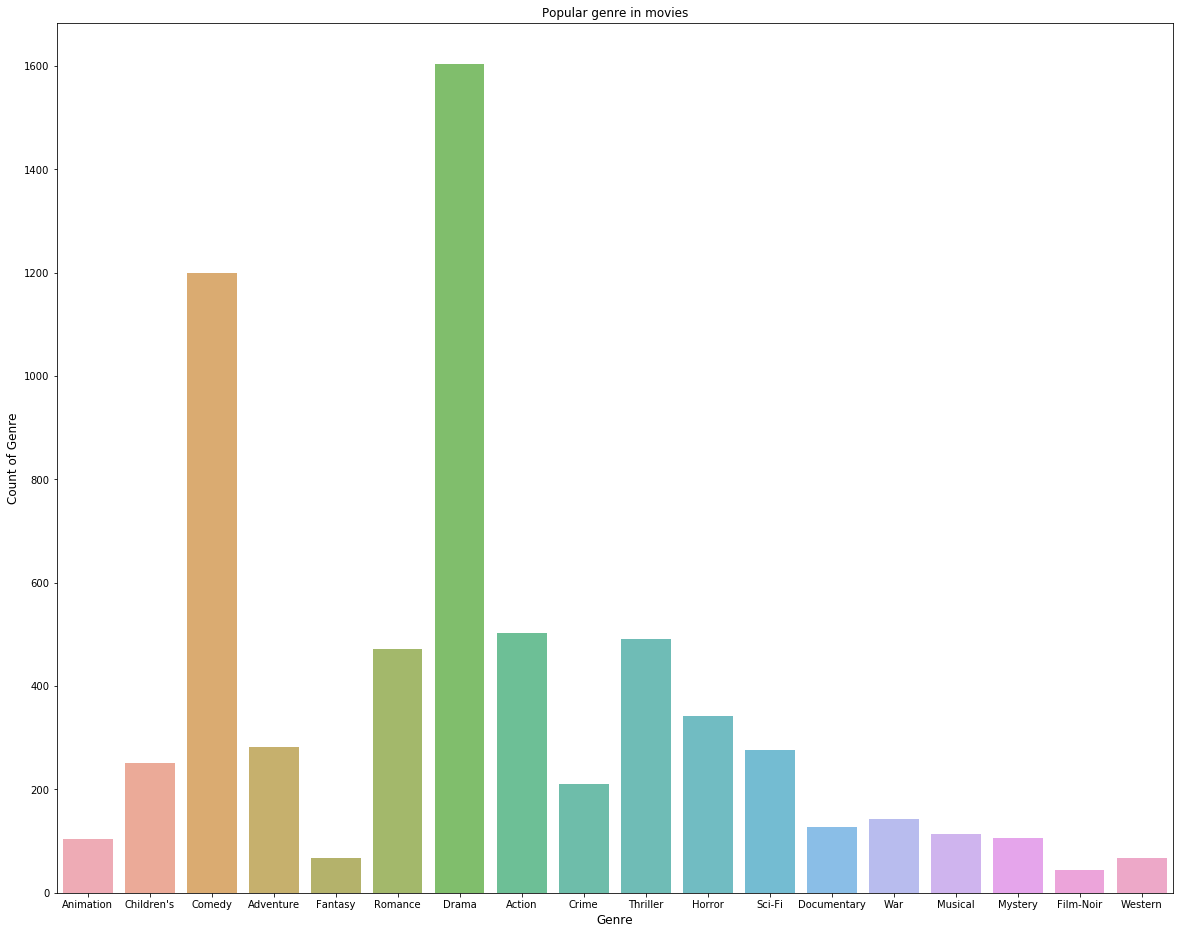

In [12]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

-----

### [분석할 유저의 정보 탐색하기]

In [13]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


-----

### `[미니 퀴즈 - 3.4]`
- `유저 데이터에 대한 탐색적 데이터 분석을 실행해 봅시다. 아래의 질문들에 답해보세요.` 
    - 유저의 성별 탐색
    - 유저의 연령대 탐색

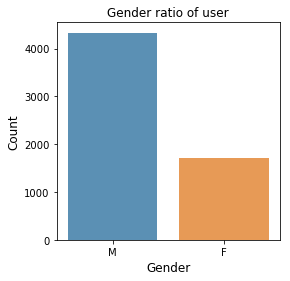

In [14]:
# 유저의 성별을 탐색합니다.
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [15]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [16]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

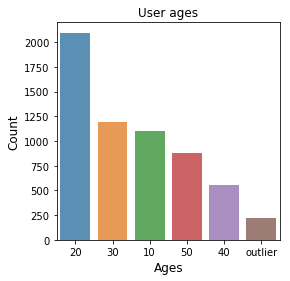

In [17]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

-----

### [평점 데이터의 정보 탐색하기]

         user_id  movie_id  rating       time
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]
movie_id
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Name: rating, Length: 3706, dtype: int64


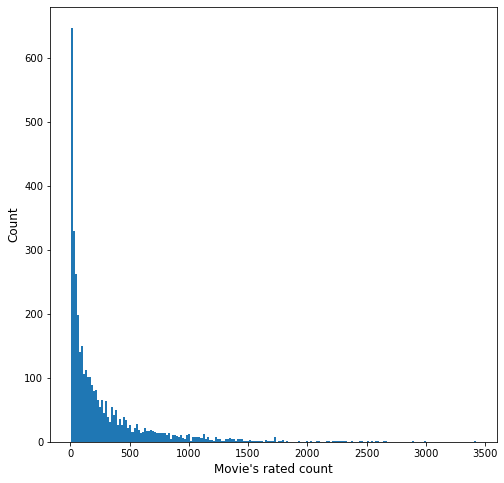

In [33]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
print(rating_data)
print(rating_data.groupby("movie_id")['rating'].count())


movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values

plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [19]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


-----

In [20]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [21]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


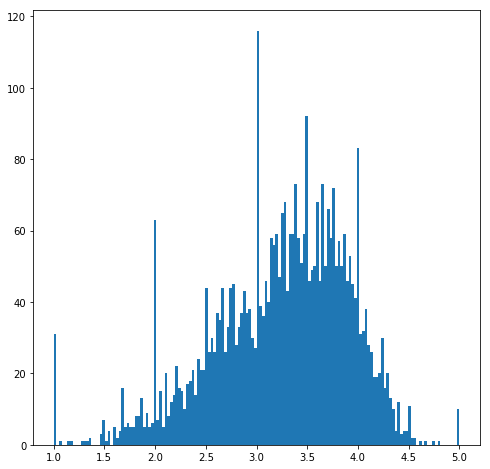

In [22]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

-----

In [23]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


-----

### `[미니 퀴즈 - 3.5]`
- `동일한 방식으로, 유저 그룹 단위의 평점 속성을 분석해 보세요.` 
    - 유저별로 평가한 영화 개수
    - 유저별로 평가한 평균 영화 점수
    - 유저별로 평가한 영화 점수의 편차

In [24]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [25]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


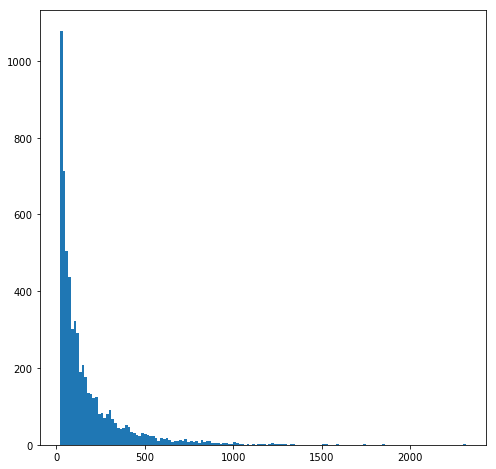

In [26]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

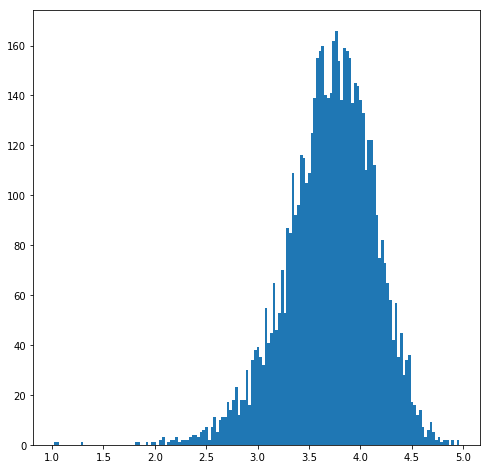

In [27]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

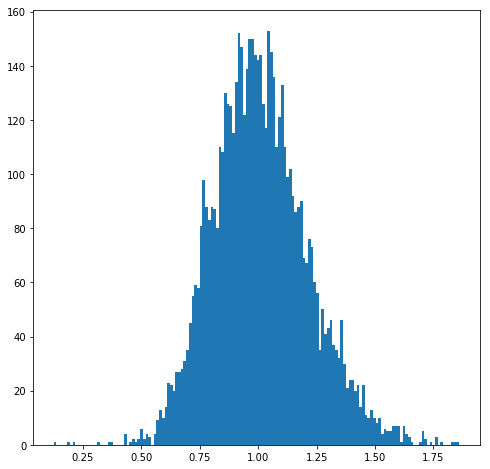

In [28]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

-----

### [user-movie 형태의 테이블로 살펴보기]

In [29]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [30]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

-----

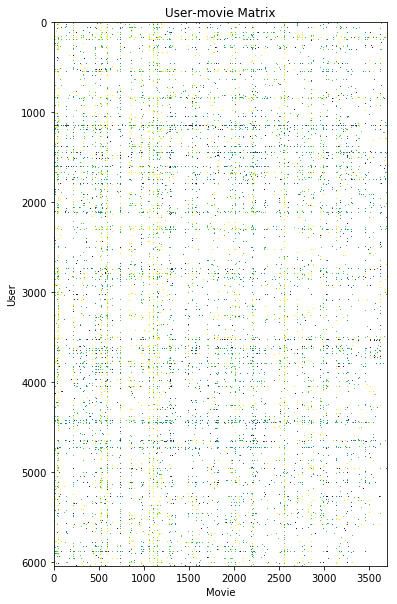

In [31]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

-----

# <Step3. 예측> : 수학적 기법을 활용한 평점 예측

### [SVD를 활용한 빈칸 채우기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
    - (env_name) `pip install surprise`

-----

##### 빈칸을 포함한 user-item 행렬 생성

In [34]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [35]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [36]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

-----

##### SVD를 이용한 빈칸 채우기 학습

In [37]:
# SVD 사용을 위한 데이터셋을 생성합니다.
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [38]:
# SVD 모델을 학습합니다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [40]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.6296480019590525
Item id 3 | predicted rating : 3.754643206353315


In [41]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.4696976612289183
Item id 2 | real rating : 4.0 | predicted rating : 3.7941315558155204
Item id 3 | real rating : 4.0 | predicted rating : 3.697523427684774
Item id 1 | real rating : 2.0 | predicted rating : 3.5474190081591224
Item id 2 | real rating : 5.0 | predicted rating : 3.8465586994620375
Item id 3 | real rating : 4.0 | predicted rating : 3.7604319324879225
Item id 2 | real rating : 5.0 | predicted rating : 3.937517232791624


-----

### [아직 평가하지 않은 영화의 점수 예측하기]

##### MovieLens 데이터에 SVD 적용하기

In [42]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 68.70 seconds


-----

##### 영화의 점수를 예측할 타겟 유저 선정

In [45]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [44]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


-----

##### 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [46]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [47]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [48]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [49]:
# 예측된 Top 10 영화
target_user_top10_predicted

[(111, 5),
 (246, 5),
 (602, 5),
 (608, 5),
 (615, 5),
 (750, 5),
 (787, 5),
 (800, 5),
 (858, 5),
 (904, 5)]

In [50]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [51]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Taxi Driver (1976) : 5
Hoop Dreams (1994) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Gate of Heavenly Peace, The (1995) : 5
Lone Star (1996) : 5
Godfather, The (1972) : 5
Rear Window (1954) : 5


In [52]:
# 타겟 유저의 기존 선호 영화와 비교합니다.
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


-----

# <Step4. 평가> : 예측 모델 평가하기

### [예측 모델의 평가 방법]

##### RMSE 계산하기

In [53]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,#학습비율
            reg_all=0.02,#
            n_epochs=100)#
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 74.49 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8614


0.8613635460629586

-----

### `[미니 퀴즈 - 3.6]`
- `SVD 예제에서 하이퍼 파라미터를 바꿔가며 RMSE를 출력해 보세요.` 
    - RMSE를 이용해 적당한 하이퍼 파라미터 n_factors를 찾아봅시다.
    - 하이퍼 파라미터 n_factors 설정 변화에 따른 RMSE 그래프를 출력해 보세요.

##### 하이퍼 파라미터 튜닝 예시

In [51]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 63.59 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8833
------------------------------------
training time of model: 66.43 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8735
------------------------------------
training time of model: 70.68 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8675
------------------------------------
training time of model: 74.03 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8641
------------------------------------
training time of model: 71.91 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8623
------------------------------------
training time of model: 77.47 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8613
------------------------------------
training time of model: 77.17 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8601
------------------------------------
training time of model: 79.30 seconds
RMSE of test data

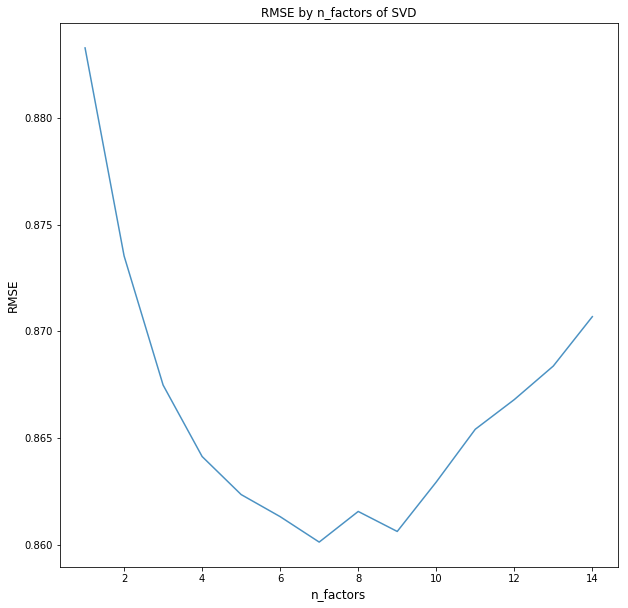

In [52]:
plt.plot(range(1, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

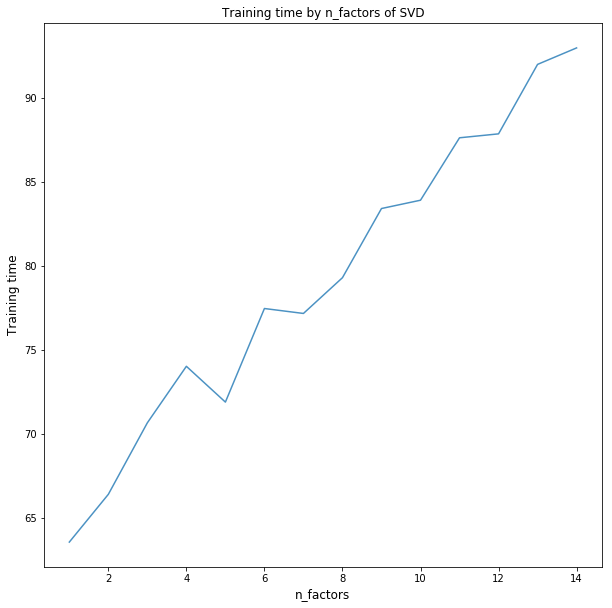

In [53]:
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

-----

### [실제 평점과의 비교 시각화]

##### 평점 예측 단계

In [54]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [55]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [56]:
target_user_movie_predict_dict

{260: 4.383354119283634,
 480: 3.563833894900237,
 1036: 3.7514429277813637,
 1097: 4.438219524247531,
 1196: 4.071821719944433,
 1198: 4.388493788585411,
 1201: 4.433966075847567,
 1210: 3.6523494542922457,
 1214: 4.506227322220238,
 1240: 4.152640037607795,
 1387: 4.483113413636387,
 1954: 4.1614079539768944,
 2028: 4.580413873901978,
 2366: 4.295487724020996,
 2692: 4.300224362296124,
 2947: 4.185420505608703,
 2951: 4.1809248227978,
 3418: 4.198270279143383,
 3468: 4.809074199608102,
 3527: 3.34962402092317,
 3702: 4.119786913461233}

In [57]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.38
movie 2 : Jurassic Park (1993) - 4 / 3.56
movie 3 : Die Hard (1988) - 4 / 3.75
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.44
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 4.07
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.39
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.43
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.65
movie 9 : Alien (1979) - 4 / 4.51
movie 10 : Terminator, The (1984) - 5 / 4.15
movie 11 : Jaws (1975) - 5 / 4.48
movie 12 : Rocky (1976) - 5 / 4.16
movie 13 : Saving Private Ryan (1998) - 5 / 4.58
movie 14 : King Kong (1933) - 4 / 4.3
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.3
movie 16 : Goldfinger (1964) - 5 / 4.19
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.18
movie 18 : Thelma & Louise (1991) - 4 / 4.2
movie 19 : Hustler, The (1961) - 5 / 4.81
movie 20 : Predator (1987) - 1 / 3.35
movie 21 : Mad Max (1979) - 4 / 4.12


-----

##### 결과의 시각화

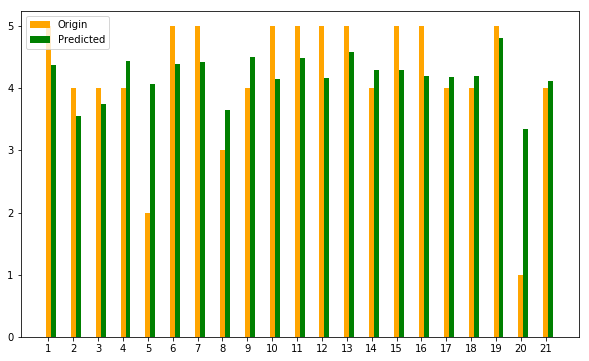

In [58]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

-----

### `한걸음 더 나아가기`
- `20대가 좋아할만한 영화 예측하기.` 

##### 20대 유저 리스트 선정

In [59]:
user_age_20_list = user_data[user_data['ages']=="20"]['user_id'].tolist()

- 평가하지 않은 user-movie rating들에 대한 예측값을 통해, 20대가 좋아할 것 같은 영화 리스트 선정

-----

##### (참고) 아래의 코드는 약 10분 이상이 소요되는 과정입니다.

In [60]:
# 평가하지 않은 user-movie rating들에 대한 예측값을 계산합니다.
preprocess_start = time.time()
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 평가하지 않은 user-movie rating 중에서, 20대의 예측값을 선별합니다.
hidden_user_age_20_movie_predict_dict = {}
for uid, mid, _, predicted_rating, _ in predictions:
    if uid in user_age_20_list:
        if mid in hidden_user_age_20_movie_predict_dict:
            hidden_user_age_20_movie_predict_dict[mid]['sum'] += predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] += 1
        else:
            hidden_user_age_20_movie_predict_dict[mid] = {}
            hidden_user_age_20_movie_predict_dict[mid]['sum'] = predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] = 1

# 영화마다 20대 유저의 rating 평균값을 계산합니다.
for movie_id, score_dict in hidden_user_age_20_movie_predict_dict.items():
    score_dict['mean'] = score_dict['sum'] / score_dict['count']
    
# Top 10 movie_id를 추출합니다.
hidden_user_age_20_movie_list = sorted(hidden_user_age_20_movie_predict_dict, 
                                       key=lambda x: (hidden_user_age_20_movie_predict_dict[x]['mean']), 
                                       reverse=True)[:10]

preprocess_end = time.time()
print("preprocess time: %.2f seconds" % (preprocess_end - preprocess_start))

preprocess time: 666.30 seconds


In [61]:
# 선정된 리스트를 출력합니다.
print("20대가 좋아할지도 모르는 영화 Top 10")
print("---------------------------------")
for movie_id in hidden_user_age_20_movie_list:
    movie_title = movie_dict[movie_id]
    age_20_rating = hidden_user_age_20_movie_predict_dict[movie_id]['mean']
    print("title:", movie_title, "| rating:", age_20_rating)

20대가 좋아할지도 모르는 영화 Top 10
---------------------------------
title: Sanjuro (1962) | rating: 4.56941687395506
title: Shawshank Redemption, The (1994) | rating: 4.549888621635932
title: Apple, The (Sib) (1998) | rating: 4.545715436471757
title: Song of Freedom (1936) | rating: 4.445731184650634
title: Schindler's List (1993) | rating: 4.444699892087616
title: Lamerica (1994) | rating: 4.420403001424143
title: Godfather, The (1972) | rating: 4.417787290740982
title: For All Mankind (1989) | rating: 4.414219442379506
title: Usual Suspects, The (1995) | rating: 4.40943308901584
title: Gate of Heavenly Peace, The (1995) | rating: 4.40625209424079
